## Import Models

In [1]:
#import required libraries — we do need the models, flatten, dense, input layers 
import sys
import cv2
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## 2. Import dataset

In [2]:
# Path for train, validation and test datasets
sys.path.append('../elpv-dataset/utils')
from utils.elpv_reader import load_dataset
images, probs, types = load_dataset()

IMAGE_SIZE = [224, 224] #Default image size for VGG19

import numpy as np
import pandas as pd

print(images.shape,probs.shape,types.shape)

# Define degradation categories based on labels
def categorize_labels(labels):
    categories = []
    for label in labels:
        if label == 0 :
            categories.append(0)
        elif label >= 0.32 and label <= 0.34:
            categories.append(1)
        elif label >= 0.65 and label <= 0.67:
            categories.append(2)
        else:
            categories.append(3)
    return categories

class_labels = categorize_labels(probs)
print(class_labels)
print(max(class_labels)+1)

(2624, 300, 300) (2624,) (2624,)
[3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 2, 0, 0, 3, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 3, 0, 3, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 3, 3, 1, 1, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 3, 1, 1, 0, 3, 3, 0, 3, 0, 1, 0, 3, 0, 0, 0, 0, 1, 3, 1, 0, 1, 3, 3, 1, 1, 1, 1, 3, 3, 2, 3, 2, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 1, 2, 2, 2, 3, 3, 2, 3, 2, 2, 0, 1, 3, 3, 0, 3, 3, 3, 2, 1, 0, 0, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 0, 0, 3, 0, 3, 3, 3, 3, 1, 3, 0, 1, 3, 0, 0, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 3, 3, 3, 3, 

# Validation and Image Dataset
## Move Images to sorted folders for keras processing ##

In [3]:
import os
import shutil
from PIL import Image

# Set the path to your source folder containing all images
source_folder = '../elpv-dataset/images'

# Set the path to your destination folder where you want to organize images by class
destination_folder = '../elpv-dataset/sorted'

# Create destination folders if they don't exist
for class_index in range(4):  # Assuming you have 4 classes
    class_folder = os.path.join(destination_folder, str(class_index))
    os.makedirs(class_folder, exist_ok=True)

# List all image files in the source folder
image_files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]

# Read the class labels from your list

# Organize images by copying them to their respective class folders
for image_file, class_label in zip(image_files, class_labels):
    class_label = int(class_label)
    source_path = os.path.join(source_folder, image_file)
    destination_path = os.path.join(destination_folder, str(class_label), image_file)
 
 # Open the image using Pillow
    try:
        image = Image.open(source_path)
    except Exception as e:
        print(f"Error opening image {source_path}: {e}")
        continue

    # Resize the image (replace (width, height) with the desired size)
    resized_image = image.resize(IMAGE_SIZE)
    # Save the resized image to the destination path
    resized_image.save(destination_path)
    # Optionally, close the image
    image.close()

print("Images organized successfully!")



Images organized successfully!


## Add into training data set structure

In [4]:
data_dir = '../elpv-dataset/sorted/'
img_height,img_width=224,224
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
print(train_ds)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2624 files belonging to 4 classes.
Using 2100 files for training.
<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
Found 2624 files belonging to 4 classes.
Using 524 files for validation.


In [5]:
#Convert layers to one hot encoding?
from tensorflow.keras.utils import to_categorical

# Assuming labels is your original list of labels
one_hot_labels = to_categorical(class_labels, num_classes=4)

In [8]:
# Use this line for VGG19 network. Create a VGG19 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output) #Output obtained on vgg16 is now flattened. 
prediction = Dense(4, activation='softmax')(x)
#Creating model object 
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
#Compile the model 
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
history = model.fit(train_ds, validation_data=val_ds, epochs=20, batch_size=32)

Epoch 1/20
66/66 [==============================] - 62s 610ms/step - loss: 5.4398 - accuracy: 0.6381 - val_loss: 2.5011 - val_accuracy: 0.6737
Epoch 2/20
66/66 [==============================] - 14s 209ms/step - loss: 1.9257 - accuracy: 0.7452 - val_loss: 4.0306 - val_accuracy: 0.7195
Epoch 3/20
66/66 [==============================] - 14s 213ms/step - loss: 1.2868 - accuracy: 0.8252 - val_loss: 3.4915 - val_accuracy: 0.6775
Epoch 4/20
66/66 [==============================] - 14s 209ms/step - loss: 0.7078 - accuracy: 0.8800 - val_loss: 2.3911 - val_accuracy: 0.6698
Epoch 5/20
66/66 [==============================] - 14s 212ms/step - loss: 0.4185 - accuracy: 0.9105 - val_loss: 3.5769 - val_accuracy: 0.6832
Epoch 6/20
66/66 [==============================] - 14s 214ms/step - loss: 0.6432 - accuracy: 0.8810 - val_loss: 3.2517 - val_accuracy: 0.6698
Epoch 7/20
66/66 [==============================] - 14s 207ms/step - loss: 0.5473 - accuracy: 0.9048 - val_loss: 3.5139 - val_accuracy: 0.6298

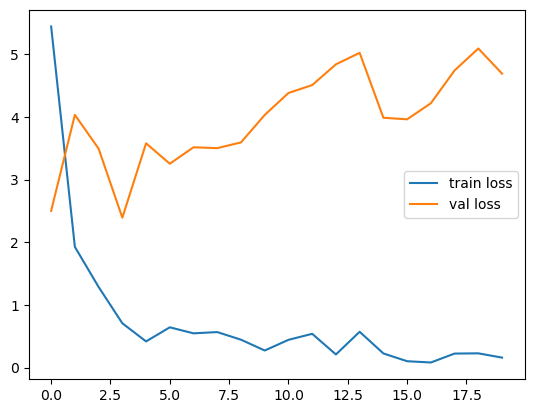

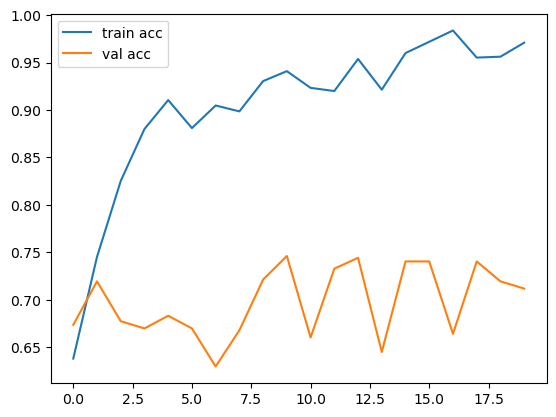

In [10]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()




Inception (GoogLe Net) Method

In [6]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

inception = InceptionV3(weights='imagenet')

x = Flatten()(inception.output) #Output obtained on vgg16 is now flattened. 
prediction3 = Dense(4, activation='softmax')(x)
#Creating model object 
model3 = Model(inputs=inception.input, outputs=prediction3)
model3.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:

#Compile the model 
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

def preprocess_image(image, label):
    # Resize the image to the expected input size of InceptionV3 (299x299 pixels)
    image = tf.image.resize(image, (299, 299))
    # Other preprocessing steps if needed
    return image, label

# Apply the preprocessing function to your datasets
train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)

history3 = model3.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=32)

Epoch 1/10
66/66 [==============================] - 49s 416ms/step - loss: 1.3066 - accuracy: 0.5824 - val_loss: 1.2762 - val_accuracy: 0.5782
Epoch 2/10
55/66 [========================>.....] - ETA: 3s - loss: 1.2362 - accuracy: 0.5733

KeyboardInterrupt: 

ResNet152V2

In [11]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
# Use this line for VGG19 network. Create a VGG19 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
resnet = ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
for layer in resnet.layers:
  layer.trainable = False

x2 = Flatten()(resnet.output) #Output obtained on vgg16 is now flattened. 
prediction2 = Dense(4, activation='softmax')(x2)
#Creating model object 
model2 = Model(inputs=resnet.input, outputs=prediction2)
model2.summary()


234553344/234545216 [==============================] - 42s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________

In [12]:
#Compile the model 
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=20, batch_size=32)

Epoch 1/20
66/66 [==============================] - 41s 497ms/step - loss: 5680.5376 - accuracy: 0.4448 - val_loss: 1376.3386 - val_accuracy: 0.6298
Epoch 2/20
66/66 [==============================] - 29s 430ms/step - loss: 2598.7563 - accuracy: 0.4605 - val_loss: 4370.5703 - val_accuracy: 0.5878
Epoch 3/20
66/66 [==============================] - 29s 447ms/step - loss: 2144.7126 - accuracy: 0.4833 - val_loss: 2950.8687 - val_accuracy: 0.6431
Epoch 4/20
66/66 [==============================] - 32s 485ms/step - loss: 1601.4460 - accuracy: 0.5095 - val_loss: 1412.9146 - val_accuracy: 0.6393
Epoch 5/20
66/66 [==============================] - 50s 770ms/step - loss: 1714.7814 - accuracy: 0.4948 - val_loss: 1750.2551 - val_accuracy: 0.6107
Epoch 6/20
66/66 [==============================] - 87s 1s/step - loss: 2225.9919 - accuracy: 0.5133 - val_loss: 2791.1611 - val_accuracy: 0.6088
Epoch 7/20
66/66 [==============================] - 88s 1s/step - loss: 1919.3939 - accuracy: 0.5348 - val_lo

In [ ]:
# loss
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()